In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hierarchical.Hierarchical_Class import prior_vac, Ddc, DDdc
from hierarchical.utility import dc
from scipy.integrate import nquad

startup


In [2]:
#supporting functions

def DM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi
    
    return C * alpha * (M ** (alpha - 1)) * ((1 + z) ** beta) * (dc(z, H0, Omega_m0, Omega_Lambda0) ** 2)

def Dz_prior_vac(M, z, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi

    return C * beta * (M ** alpha) * ((1 + z) ** (beta - 1)) * (dc(z, H0, Omega_m0, Omega_Lambda0) ** 2) + 2 * C * (M ** alpha) * ((1 + z)**beta) * dc(z, H0, Omega_m0, Omega_Lambda0) * Ddc(z,H0,Omega_m0,Omega_Lambda0)

def DDM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi
    
    return C * alpha * (alpha-1) * (M ** (alpha-2)) * ((1+z)**beta) * (dc(z,H0,Omega_m0,Omega_Lambda0)**2)

def DDz_prior_vac(M, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi

    """
    Computes the expression given in Mathematica syntax:
    
    (-1 + beta) * beta * C * M^alpha * (1 + z)^(-2 + beta) * dc[z]^2 
    + 4 * beta * C * M^alpha * (1 + z)^(-1 + beta) * dc[z] * Derivative[1][dc][z] 
    + 2 * C * M^alpha * (1 + z)^beta * Derivative[1][dc][z]^2 
    + 2 * C * M^alpha * (1 + z)^beta * dc[z] * (dc''[z])
    
    Parameters:
        beta, C, M, alpha, z : float
            Constants and variable in the expression
        dc : float
            dc[z] (function value at z)
        Ddc : float
            Derivative of dc with respect to z (dc'[z])
        DDdc : float
            Second derivative of dc with respect to z (dc''[z])
    """

    term1 = (-1 + beta) * beta * C * M ** alpha * (1 + z) ** (-2 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0)** 2
    term2 = 4 * beta * C * M ** alpha * (1 + z) ** (-1 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0)* Ddc(z,H0,Omega_m0,Omega_Lambda0)
    term3 = 2 * C * M ** alpha * (1 + z) ** beta * Ddc(z,H0,Omega_m0,Omega_Lambda0) ** 2
    term4 = 2 * C * M ** alpha * (1 + z) ** beta * dc(z,H0,Omega_m0,Omega_Lambda0) * DDdc(z,H0,Omega_m0,Omega_Lambda0)
    
    return term1 + term2 + term3 + term4

def DMDz_prior_vac(M, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar):
    C = K * ((1/Mstar)**alpha) * 4 * np.pi

    """
    Computes the expression:
    
    alpha * beta * C * M^(-1 + alpha) * (1 + z)^(-1 + beta) * dc[z]^2 
    + 2 * alpha * C * M^(-1 + alpha) * (1 + z)^beta * dc[z] * Derivative[1][dc][z]
    
    Parameters:
        alpha, beta, C, M, z : float
            Constants and variable in the expression
        dc : float
            dc[z] (function value at z)
        Ddc : float
            Derivative of dc with respect to z (dc'[z])
    """
    term1 = alpha * beta * C * M ** (-1 + alpha) * (1 + z) ** (-1 + beta) * dc(z,H0,Omega_m0,Omega_Lambda0) ** 2
    term2 = 2 * alpha * C * M ** (-1 + alpha) * (1 + z) ** beta * dc(z,H0,Omega_m0,Omega_Lambda0) * Ddc(z,H0,Omega_m0,Omega_Lambda0)
    
    return term1 + term2

In [3]:
def prior_taylor(M, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    
    Mhat, zhat = theta_hat
    
    term_0 = prior_vac(Mhat, zhat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar)
    
    term_1 = ((M - Mhat) * DM_prior_vac(Mhat, zhat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) + 
              (z - zhat) * Dz_prior_vac(Mhat, zhat, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar))
    
    term_2 = (((M - Mhat)**2/2) * DDM_prior_vac(M, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) + 
              ((z - zhat)**2/2) * DDz_prior_vac(M, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar) + 
              (M - Mhat) * (z - zhat) * DMDz_prior_vac(M, z, K, alpha, beta,H0,Omega_m0,Omega_Lambda0, Mstar))
    
    return (
        term_0 
        + term_1 
        + term_2
    )

def likelihood(M, z, theta_hat):
    
    theta = np.array((M,z))
    
    assert len(theta) == len(theta_hat)
    
    Fisher = 1e-10 * np.eye(len(theta))
    
    return (np.linalg.det(Fisher)**(1/2))/((2 * np.pi)**(len(Fisher)/2)) * np.exp(-0.5 * np.array(theta - theta_hat)@Fisher@np.array(theta - theta_hat))

Mhat = 1e6
zhat = 0.5
theta_hat = np.array((Mhat, zhat))

K = 5e-3
Mstar = 3e6
alpha = 0.2
beta = 0.2

Omega_m0 = 0.30
Omega_Lambda0 = 0.70
H0 = 70e3

In [4]:
def integrand_exact(M, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    return prior_vac(M, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * likelihood(M, z, theta_hat)

def integrand_taylor(M, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar):
    return prior_taylor(M, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * likelihood(M, z, theta_hat)

results_exact, error_exact = nquad(integrand_exact, 
                                   ranges=[[5e5,5e6],[0.01,10.0]],
                                   args=(theta_hat,K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))

results_taylor, error_taylor = nquad(integrand_taylor, 
                                    ranges=[[5e5,5e6],[0.01,10.0]],
                                    args=(theta_hat,K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))

3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.70886

In [5]:
(results_exact, error_exact), (results_taylor, error_taylor), results_exact/results_taylor

((160.7919676749487, 3.425878635419533e-08),
 (101.31040292760616, 1.9524184780268476e-08),
 1.5871219838089732)

3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.70886

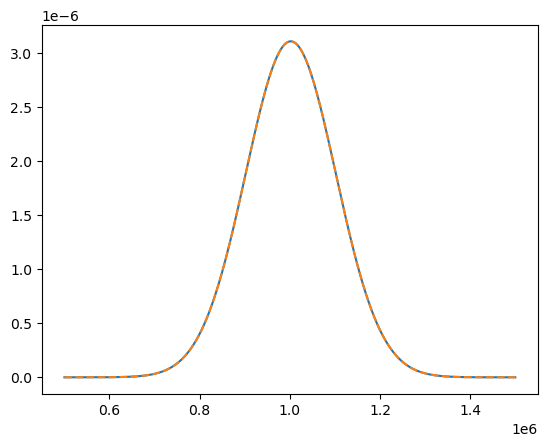

In [6]:
Mrange = np.linspace(5e5, 1.5e6,1000)

integrand_ex = []
integrand_tay = []
for M in Mrange:
    integrand_ex.append(integrand_exact(M, zhat, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    integrand_tay.append(integrand_taylor(M, zhat, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    
plt.plot(Mrange, integrand_ex)
plt.plot(Mrange, integrand_tay,linestyle='--')
#plt.yscale('log')
#plt.xscale('log')

print(sum(integrand_ex),sum(integrand_tay))

3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.708864659019
3272.70886

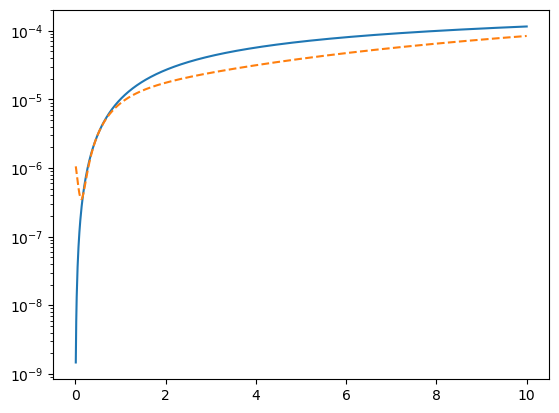

In [7]:
zrange = np.linspace(0.01, 10.,1000)

integrand_ex = []
integrand_tay = []
for z in zrange:
    integrand_ex.append(integrand_exact(Mhat, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    integrand_tay.append(integrand_taylor(Mhat, z, theta_hat, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar))
    
plt.plot(zrange, integrand_ex)
plt.plot(zrange, integrand_tay,linestyle='--')
plt.yscale('log')
#plt.xscale('log')

print(sum(integrand_ex)/sum(integrand_tay))